In [13]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage
from dotenv import load_dotenv
import json

# import logging

# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )

_ = load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    def __init__(self, model_breakdown, model_qualification, model_decision, tools):
        graph = StateGraph(AgentState)

        graph.add_node("breakdown_agent", self.call_openai_breakdown_tasks)
        graph.add_node("qualification_agent", self.call_openai_qualification)
        graph.add_node("decision_agent", self.call_openai_decision)
        graph.add_node("take_action", self.take_action)

        graph.add_conditional_edges(
            "breakdown_agent",
            self.exists_action,
            {True: "take_action", False: "decision_agent"}
        )
        graph.add_edge("take_action", "qualification_agent")
        graph.add_conditional_edges(
            "qualification_agent",
            self.exists_action,
            {True: "take_action", False: "breakdown_agent"}
        )
        graph.add_edge("decision_agent", END)

        graph.set_entry_point("breakdown_agent")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model_breakdown = model_breakdown.bind_tools(tools)
        self.model_qualification = model_qualification.bind_tools(tools)
        self.model_decision = model_decision.bind_tools(tools)


    def call_openai_breakdown_tasks(self, state: AgentState):
        messages = state['messages']

        system_query = """You are a breakdown sub-agent, your task is to break down the query into multiple executable steps based on the available tools. \
            You are allowed to make multiple calls (either together or in sequence). \
            Only look up information when you are sure of what you want. \
            If you need to look up some information before asking a follow up question, you are allowed to do that!"""

        messages = [SystemMessage(content=system_query)] + messages
        message = self.model_breakdown.invoke(messages)
        new_state = {'messages': [message]}
        return new_state
    
    def call_openai_qualification(self, state: AgentState):
        initial_message = state["messages"][0]
        messages = state['messages']

        system_query = f"You are a qualification sub-agent, your task is to make sure that the informations provided covered fully this query: {initial_message}."

        messages = [SystemMessage(content=system_query)] + messages
        message = self.model_qualification.invoke(messages)
        new_state = {'messages': [message]}
        return new_state

    def call_openai_decision(self, state: AgentState):
        initial_message = state["messages"][0]
        messages = state['messages']

        system_query = f"You are a decision sub-agent, your task is to decide which booking is the best based on this query: {initial_message}."

        messages = [SystemMessage(content=system_query)] + messages
        message = self.model_decision.invoke(messages)
        new_state = {'messages': [message]}
        return new_state

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("To the filter model!")
        return {'messages': results}

In [6]:
import os
from dotenv import load_dotenv
from pinecone import Pinecone
import time
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
import uuid
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
import requests
# from semantic_router.encoders import OpenAIEncoder
# from semantic_chunkers import StatisticalChunker

env_path = os.path.join(os.getcwd(), '..', '.env')

_ = load_dotenv(dotenv_path=env_path)

pinecone_api_key = os.getenv('PINECONE_API_KEY')
openai_api_key = os.getenv('OPENAI_API_KEY')

pc = Pinecone(api_key=pinecone_api_key)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
open_ai_embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)
text_splitter = SemanticChunker(open_ai_embedding, breakpoint_threshold_type="gradient")

class Helper:
    def upsert_method(self, vector_list, index_name="test2", namespace="ns1"):
        while not pc.describe_index(index_name).status['ready']:
            time.sleep(1)

        index = pc.Index(index_name)

        vectors = []
        for v in vector_list:
            vectors.append((str(uuid.uuid4()), v['embedding'], {'sentence' : v['sentence']}))

        return index.upsert(
            vectors=vectors,
            namespace=namespace
        ).to_dict()

    def query_method(self, vector_list, top_k=10, index_name="test2", namespace="ns1"):
        while not pc.describe_index(index_name).status['ready']:
            time.sleep(1)

        index = pc.Index(index_name)

        result = []
        seen_ids = set()
        for v in vector_list:
            res = index.query(
                namespace=namespace,
                vector=v['embedding'],
                top_k=top_k,
                include_values=True,
                include_metadata=True,
            )

            for match in res['matches']:
                if match['id'] not in seen_ids:
                    result.append(match['metadata']['sentence'])
                    seen_ids.add(match['id'])

        return {'similar_sentences' : result}
    
    def embed_sentences(self, sentences):
        embeddings = model.encode(sentences)
        embed_list = []
        for i in range(len(embeddings)):
            embed_list.append({'embedding' : embeddings[i], 'sentence' : sentences[i]})
        return embed_list

    def embed_sentences_openai(self, sentences):
        embed_list = []
        for i in range(len(sentences)):
            embedding = open_ai_embedding.embed_query(sentences[i])
            embed_list.append({'embedding' : embedding, 'sentence' : sentences[i]})
        return embed_list

    def split_text_into_sentences(self, text):
        # chunks = chunker(docs=[text]) # don't use this
        sentences = sent_tokenize(text)
        # docs = text_splitter.create_documents([text])
        # sentences = []
        # for doc in docs:
        #     sentences.append(doc.page_content)
        return sentences

    
db_helper_obj = Helper()

In [7]:
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
import uuid

@tool
def query_tool(sub_queries: list) -> ToolMessage:
    """This is a query tool"""

    if not isinstance(sub_queries, list):
        raise ValueError("Expected 'sub_queries' to be a list of strings.")

    res = []
    for sub_query in sub_queries:
        sentences = db_helper_obj.split_text_into_sentences(sub_query)
        vector = db_helper_obj.embed_sentences_openai(sentences)
        res.append(db_helper_obj.query_method(vector))
    
    tool_call_id = f"tool_call_{uuid.uuid4()}"
    return ToolMessage(name=query_tool.name, content={"results": res}, tool_call_id=tool_call_id)

In [8]:
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
import uuid

@tool
def upsert_tool(text: str) -> ToolMessage:
    """This is an upsert tool"""

    if not isinstance(text, str):
        raise ValueError("Expected 'text' to be a string.")
    
    sentences = db_helper_obj.split_text_into_sentences(text)
    vector = db_helper_obj.embed_sentences_openai(sentences)
    res = db_helper_obj.upsert_method(vector)
    
    tool_call_id = f"tool_call_{uuid.uuid4()}"
    return ToolMessage(name=upsert_tool.name, content={"results": res}, tool_call_id=tool_call_id)

In [9]:
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
import uuid

@tool
def search_tool(queries: list) -> ToolMessage:
    """This is a search tool"""

    tool_call_id = f"tool_call_{uuid.uuid4()}"
    return ToolMessage(name=search_tool.name, content={"results": queries}, tool_call_id=tool_call_id)

In [15]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

model_breakdown = ChatOpenAI(model="gpt-4o-mini")  # Updated to GPT-4o-mini
model_qualification = ChatOpenAI(model="gpt-4o-mini")  # Updated to GPT-4o-mini
model_decision = ChatOpenAI(model="gpt-4o-mini")  # Updated to GPT-4o-mini

tools = [query_tool, upsert_tool, search_tool]


abot = Agent(model_breakdown, model_qualification, model_decision, tools)

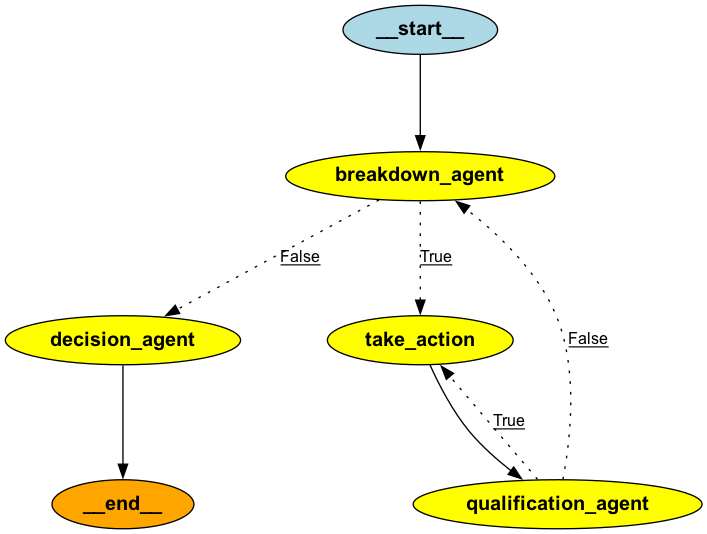

In [16]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())